### Load Data, drop empty Txt and Settings
----

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import csv

In [2]:
## SETTINGS

# active models
SET_NN_active = False

SET_track_scores = True

SET_SVM_active = False

SET_datapath = "data_pp_cut.json"
SET_name_outputfile = "performance_270323.csv"

df = pd.read_json(SET_datapath, orient="columns")

df.drop(df[df.comment_text.str.len() == 0].index, inplace=True)
df.reset_index(drop=True, inplace=True)

df.head()

,comment_text,toxic
0,u created request scholarlyarticles awaiting c...,1
1,looking lgbt profession category point get beh...,1
2,"new york city regulation regarding removal, , ...",0
3,thank speedy rollback would believe first time...,1
4,want talk stuff perfectly willing refer commen...,0


### Word Embedding

----

#### TFidf Vectorizer

In [3]:
vectorizer_tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=500)
X = vectorizer_tfidf.fit_transform(df["comment_text"].values.tolist()).toarray()
y = df['toxic'].values

### Split Data for Models
----

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99, stratify=y)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1181, 500)
X_test shape: (296, 500)
y_train shape: (1181,)
y_test shape: (296,)


### Train Models and get Scores

----

#### Try... Neural Network

In [6]:
if SET_NN_active:

    import numpy as np
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Activation, Flatten


    # convert labels to categorical data
    num_classes = 2
    input_shape = X_train.shape


    # define the model architecture
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.15))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['precission'])

    model.fit(X_train, y_train, batch_size=1, epochs=5, validation_data=(X_test, y_test))

In [7]:
def model_train(model, X_train, X_test, y_train, y_test):
    model.fit(X_train,y_train)
    y_pred_tr = model.predict(X_train)
    y_pred = model.predict(X_test)

    print("--------------------Training Performance---------------------")
    print(accuracy_score(y_train,y_pred_tr))
    print(classification_report(y_train,y_pred_tr))
    print("-------------------------------------------------------------")
    print("--------------------Testing Performance----------------------")
    print(accuracy_score(y_test,y_pred))
    print(classification_report(y_test,y_pred))

    sns.heatmap(confusion_matrix(y_test, y_pred),cmap='viridis',annot=True,fmt='.4g')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.show()

    if SET_track_scores:

        report = classification_report(y_test,y_pred, output_dict=True)
        # print(report)
        recall = report["macro avg"]["recall"]
        precision = report["macro avg"]["precision"]
        f1_score = report["macro avg"]["f1-score"]

        # Save recall value in a CSV file
        with open(SET_name_outputfile, mode='a') as csv_file:
            fieldnames = ['Model', 'WordEmbedding', 'Precision', 'Recall', 'F1-Score']
            writer = csv.DictWriter(csv_file, fieldnames=fieldnames)

            # adds header in case csv is empty
            if csv_file.tell() == 0:
                writer.writeheader()

            writer.writerow({'Model': model.__class__.__name__, 'WordEmbedding': 'TFidf', 'Precision': precision, 'Recall': recall, 'F1-Score': f1_score})

#### Naive Bayes:

--------------------Training Performance---------------------
0.7535986452159187
              precision    recall  f1-score   support

           0       0.74      0.96      0.83       757
           1       0.83      0.39      0.53       424

    accuracy                           0.75      1181
   macro avg       0.78      0.67      0.68      1181
weighted avg       0.77      0.75      0.73      1181

-------------------------------------------------------------
--------------------Testing Performance----------------------
0.6824324324324325
              precision    recall  f1-score   support

           0       0.72      0.87      0.78       197
           1       0.54      0.31      0.40        99

    accuracy                           0.68       296
   macro avg       0.63      0.59      0.59       296
weighted avg       0.66      0.68      0.65       296



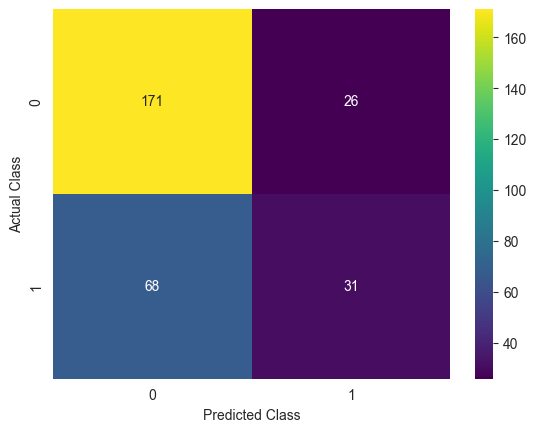

In [8]:
modelNB = MultinomialNB()
model_train(modelNB, X_train, X_test, y_train, y_test)

#### Support Vector Machine

--------------------Training Performance---------------------
0.8687552921253175
              precision    recall  f1-score   support

           0       0.83      0.99      0.91       757
           1       0.99      0.64      0.78       424

    accuracy                           0.87      1181
   macro avg       0.91      0.82      0.84      1181
weighted avg       0.89      0.87      0.86      1181

-------------------------------------------------------------
--------------------Testing Performance----------------------
0.6993243243243243
              precision    recall  f1-score   support

           0       0.70      0.97      0.81       197
           1       0.75      0.15      0.25        99

    accuracy                           0.70       296
   macro avg       0.72      0.56      0.53       296
weighted avg       0.71      0.70      0.62       296



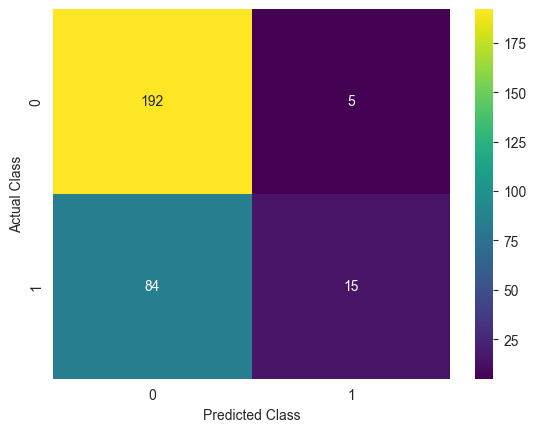

In [9]:
if SET_SVM_active:
    from sklearn.svm import SVC
    modelSVM = SVC()
    model_train(modelSVM, X_train, X_test, y_train, y_test)

#### Logistic Regression (Best Model) :

--------------------Training Performance---------------------
0.7790008467400508
              precision    recall  f1-score   support

           0       0.76      0.97      0.85       757
           1       0.89      0.44      0.59       424

    accuracy                           0.78      1181
   macro avg       0.82      0.70      0.72      1181
weighted avg       0.80      0.78      0.76      1181

-------------------------------------------------------------
--------------------Testing Performance----------------------
0.668918918918919
              precision    recall  f1-score   support

           0       0.71      0.85      0.77       197
           1       0.51      0.30      0.38        99

    accuracy                           0.67       296
   macro avg       0.61      0.58      0.58       296
weighted avg       0.64      0.67      0.64       296



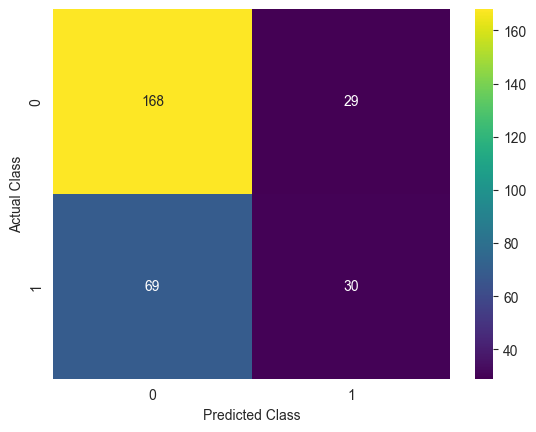

In [10]:
modelLR = LogisticRegression(max_iter=1000)
model_train(modelLR, X_train, X_test, y_train, y_test)

#### Random forest:

--------------------Training Performance---------------------
0.6926333615580017
              precision    recall  f1-score   support

           0       0.68      1.00      0.81       757
           1       1.00      0.14      0.25       424

    accuracy                           0.69      1181
   macro avg       0.84      0.57      0.53      1181
weighted avg       0.79      0.69      0.61      1181

-------------------------------------------------------------
--------------------Testing Performance----------------------
0.7364864864864865
              precision    recall  f1-score   support

           0       0.72      0.99      0.83       197
           1       0.96      0.22      0.36        99

    accuracy                           0.74       296
   macro avg       0.84      0.61      0.60       296
weighted avg       0.80      0.74      0.68       296



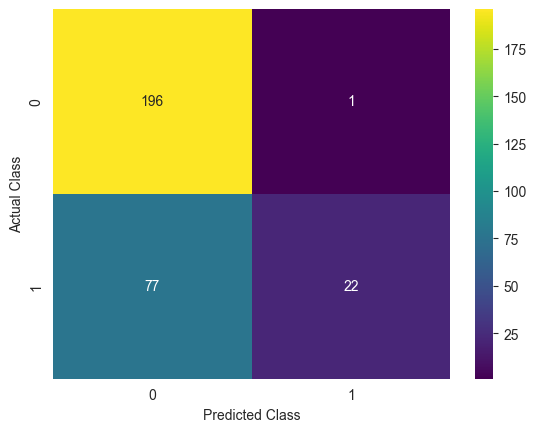

In [11]:
model = RandomForestClassifier(n_estimators=100,max_depth=10,max_features='sqrt')
model_train(model, X_train, X_test, y_train, y_test)

In [12]:
print("finished")

finished
